In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 
import os

In [29]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner as kt

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [31]:
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [32]:
model = tf.keras.models.load_model("models/LSTM_1")

In [33]:
# model = tf.keras.models.load_model("models/LSTM_2")

In [34]:
df = pd.read_csv("/home/ubuntu/datasets/covid19vaccinesbycountybydemographic.csv")

df

,county,county_type,demographic_category,demographic_value,est_population,est_age_12plus_pop,est_age_5plus_pop,administered_date,partially_vaccinated,total_partially_vaccinated,...,cumulative_fully_vaccinated,at_least_one_dose,cumulative_at_least_one_dose,cumulative_unvax_total_pop,cumulative_unvax_12plus_pop,cumulative_unvax_5plus_pop,suppress_data,up_to_date_count,cumulative_up_to_date_count,administered_year
0,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-23,0.0,17088.0,...,69129.0,0.0,86225.0,NaN,NaN,NaN,False,0,8609,2024
1,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-22,0.0,17088.0,...,69129.0,0.0,86225.0,NaN,NaN,NaN,False,0,8609,2024
2,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-21,4.0,17088.0,...,69129.0,4.0,86225.0,NaN,NaN,NaN,False,8,8609,2024
3,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-20,0.0,17084.0,...,69129.0,0.0,86221.0,NaN,NaN,NaN,False,0,8601,2024
4,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-19,2.0,17084.0,...,69129.0,2.0,86221.0,NaN,NaN,NaN,False,2,8601,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185832,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-31,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
2185833,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-30,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
2185834,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-29,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
2185835,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-28,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020


In [35]:
df = df.iloc[::-1].reset_index(drop=True)

df

,county,county_type,demographic_category,demographic_value,est_population,est_age_12plus_pop,est_age_5plus_pop,administered_date,partially_vaccinated,total_partially_vaccinated,...,cumulative_fully_vaccinated,at_least_one_dose,cumulative_at_least_one_dose,cumulative_unvax_total_pop,cumulative_unvax_12plus_pop,cumulative_unvax_5plus_pop,suppress_data,up_to_date_count,cumulative_up_to_date_count,administered_year
0,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-27,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
1,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-28,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
2,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-29,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
3,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-30,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
4,Yuba,DERIVED FROM RECIP ZIP,VEM Quartile,4,39.0,28.0,39.0,2020-07-31,0.0,0.0,...,0.0,0.0,0.0,39.0,28.0,39.0,False,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185832,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-19,2.0,17084.0,...,69129.0,2.0,86221.0,NaN,NaN,NaN,False,2,8601,2024
2185833,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-20,0.0,17084.0,...,69129.0,0.0,86221.0,NaN,NaN,NaN,False,0,8601,2024
2185834,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-21,4.0,17088.0,...,69129.0,4.0,86225.0,NaN,NaN,NaN,False,8,8609,2024
2185835,NaN,HPI_RCP_TRACT,HPI Quartile Census Mixed,1,NaN,NaN,NaN,2024-08-22,0.0,17088.0,...,69129.0,0.0,86225.0,NaN,NaN,NaN,False,0,8609,2024


In [36]:
df['administered_date'] = pd.to_datetime(df['administered_date'])

In [37]:
df = df[df['demographic_category'].str.contains("Race/Ethnicity")]

df = df[~df['demographic_value'].str.contains("Other Race|Unknown")]

In [38]:
encoder = LabelEncoder()
df['county_encoded'] = encoder.fit_transform(df['county'])
df['demographic_encoded'] = encoder.fit_transform(df['demographic_value'])

In [39]:
df['group'] = df['county_encoded'].astype(str) + "_" + df['demographic_encoded'].astype(str)

df['group']

5956       58_6
5957       58_6
5958       58_6
5959       58_6
5960       58_6
           ... 
2161592     0_0
2161593     0_0
2161594     0_0
2161595     0_0
2161596     0_0
Name: group, Length: 614957, dtype: object

In [40]:
df['percent_fully_vaccinated'] = df['cumulative_fully_vaccinated'] / df['est_population']

df = df[df['percent_fully_vaccinated'] != 0]
df = df[df['percent_fully_vaccinated'].notnull()]
df['percent_fully_vaccinated'] = df['percent_fully_vaccinated'].clip(upper=1)

In [41]:
prep_df = df[['percent_fully_vaccinated', 'county_encoded', 'demographic_encoded', 'group']]

prep_df = prep_df.reset_index(drop = True)

prep_df

,percent_fully_vaccinated,county_encoded,demographic_encoded,group
0,0.000025,58,6,58_6
1,0.000025,58,6,58_6
2,0.000025,58,6,58_6
3,0.000025,58,6,58_6
4,0.000025,58,6,58_6
...,...,...,...,...
522139,1.000000,0,0,0_0
522140,1.000000,0,0,0_0
522141,1.000000,0,0,0_0
522142,1.000000,0,0,0_0


In [42]:
prep_df = prep_df[prep_df['percent_fully_vaccinated'] != 0]
prep_df = prep_df[prep_df['percent_fully_vaccinated'].notnull()]


prep_df

,percent_fully_vaccinated,county_encoded,demographic_encoded,group
0,0.000025,58,6,58_6
1,0.000025,58,6,58_6
2,0.000025,58,6,58_6
3,0.000025,58,6,58_6
4,0.000025,58,6,58_6
...,...,...,...,...
522139,1.000000,0,0,0_0
522140,1.000000,0,0,0_0
522141,1.000000,0,0,0_0
522142,1.000000,0,0,0_0


In [43]:
time_step = 10
validation_percentage = 0.05

X_train = []
y_train = []
X_val = []
y_val = []

grouped_county = df.groupby('group')

for name, group in grouped_county:
    values = group[['percent_fully_vaccinated', 'county_encoded', 'demographic_encoded']].values

    validation_split = int(len(values) * validation_percentage)
    
    if len(values) > time_step + validation_split:
        for i in range(len(values) - time_step - validation_split):
            X_train.append(values[i:i+time_step, :])
            y_train.append(values[i+time_step, 0])
        
        for i in range(len(values) - time_step - validation_split, len(values) - time_step):
            X_val.append(values[i:i+time_step, :])
            y_val.append(values[i+time_step, 0])


X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [44]:
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (492355, 10, 3)
Validation data shape: (25959, 10, 3)


In [45]:
print("Labels data shape:", y_train.shape)
print("Validation data shape:", y_val.shape)

Labels data shape: (492355,)
Validation data shape: (25959,)


In [46]:
prep_df = prep_df.drop(columns=['group'])

prep_df

,percent_fully_vaccinated,county_encoded,demographic_encoded
0,0.000025,58,6
1,0.000025,58,6
2,0.000025,58,6
3,0.000025,58,6
4,0.000025,58,6
...,...,...,...
522139,1.000000,0,0
522140,1.000000,0,0
522141,1.000000,0,0
522142,1.000000,0,0


In [47]:
encoded_county = list(zip(df['county_encoded'].unique(), df['county'].unique()))

sorted(encoded_county, key=lambda x: x[0])

[(0, 'Alameda'),
 (1, 'Alpine'),
 (2, 'Amador'),
 (3, 'Butte'),
 (4, 'Calaveras'),
 (5, 'Colusa'),
 (6, 'Contra Costa'),
 (7, 'Del Norte'),
 (8, 'El Dorado'),
 (9, 'Fresno'),
 (10, 'Glenn'),
 (11, 'Humboldt'),
 (12, 'Imperial'),
 (13, 'Inyo'),
 (14, 'Kern'),
 (15, 'Kings'),
 (16, 'Lake'),
 (17, 'Lassen'),
 (18, 'Los Angeles'),
 (19, 'Madera'),
 (20, 'Marin'),
 (21, 'Mariposa'),
 (22, 'Mendocino'),
 (23, 'Merced'),
 (24, 'Modoc'),
 (25, 'Mono'),
 (26, 'Monterey'),
 (27, 'Napa'),
 (28, 'Nevada'),
 (29, 'Orange'),
 (30, 'Placer'),
 (31, 'Plumas'),
 (32, 'Riverside'),
 (33, 'Sacramento'),
 (34, 'San Benito'),
 (35, 'San Bernardino'),
 (36, 'San Diego'),
 (37, 'San Francisco'),
 (38, 'San Joaquin'),
 (39, 'San Luis Obispo'),
 (40, 'San Mateo'),
 (41, 'Santa Barbara'),
 (42, 'Santa Clara'),
 (43, 'Santa Cruz'),
 (44, 'Shasta'),
 (45, 'Sierra'),
 (46, 'Siskiyou'),
 (47, 'Solano'),
 (48, 'Sonoma'),
 (49, 'Stanislaus'),
 (50, 'Statewide'),
 (51, 'Sutter'),
 (52, 'Tehama'),
 (53, 'Trinity'),
 (5

In [48]:
encoded_ethnicity = list(zip(df['demographic_value'].unique(), df['demographic_encoded'].unique()))

sorted(encoded_ethnicity, key=lambda x: x[0])

[('American Indian or Alaska Native', 0),
 ('Asian', 1),
 ('Black or African American', 2),
 ('Latino', 3),
 ('Multiracial', 4),
 ('Native Hawaiian or Other Pacific Islander', 5),
 ('White', 6)]

In [51]:
def forecast(data, prep_df, county_encode, ethnicity_encode, forecast_days, model): 
    df = data[(data['county_encoded'] == county_encode) & (data['demographic_encoded'] == ethnicity_encode)]
    df = df.reset_index(drop=True)

    prep_df = prep_df[(prep_df['county_encoded'] == county_encode) & (prep_df['demographic_encoded'] == ethnicity_encode)]
    prep_df = prep_df.reset_index(drop = True)
    prep_df = prep_df.tail(10)

    forecast_array = prep_df.values
    forecast_array = forecast_array.reshape((1,10,3))
    
    predictions = []

    for i in range(forecast_days):
        next_prediction = model.predict(forecast_array)
        next_prediction = next_prediction.reshape((1,1,1))


        next_input = np.array([[[next_prediction[0,0,0], forecast_array[0,-1,1], forecast_array[0,-1,2]]]])

        forecast_array = np.append(forecast_array[:,1:,:], next_input, axis = 1)

        predictions.append(next_prediction[0,0,0])

    predictions = np.array(predictions)

    last_date = df['administered_date'].max()

    next_month = pd.date_range(start = last_date, periods = forecast_days+1)

    next_month = next_month[1:]

    index = df[df['administered_date'] == "2022-01-01"].index[0]
    # index = df['administered_date'].idxmin()

    
    past_df = df[index:]

    past_df = past_df[['administered_date', 'percent_fully_vaccinated']]

    connect_point = pd.DataFrame({'administered_date': [past_df['administered_date'].iloc[-1]],
                                  'percent_fully_vaccinated': [past_df["percent_fully_vaccinated"].iloc[-1]]}, index = [0])

    predictions_df = pd.DataFrame({'administered_date': next_month,
                                  'percent_fully_vaccinated': predictions})
    
    predictions_df = pd.concat([connect_point, predictions_df]).reset_index(drop=True)
    


    plt.figure(figsize=(14, 7))
    plt.plot(past_df['administered_date'], past_df['percent_fully_vaccinated'], color = 'r', marker = 'o')
    plt.plot(predictions_df['administered_date'], predictions_df['percent_fully_vaccinated'], color = 'b', marker = 'o')
    plt.xticks(rotation = 45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


/tmp/ipykernel_942/1633779360.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


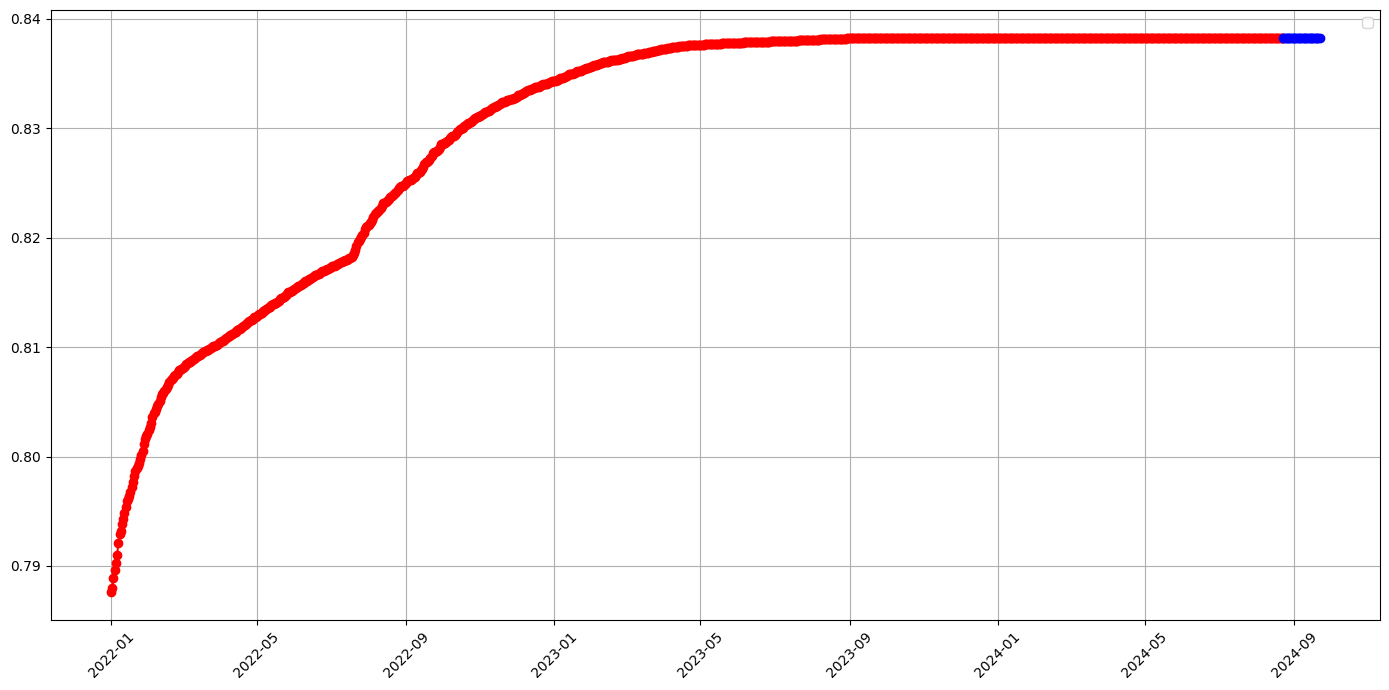

In [52]:
forecast(df,prep_df,  42, 1, 30, model)